In [1]:
%load_ext autoreload
%autoreload 2

import rlpg.envs.cars as cars
import rlpg.envs.types as rl_envs
import rlpg.loaders as rl_loaders
import rlpg.trainers.vae_trainer as vae_trainer

import torchvision.transforms.functional as ttf

import os
import matplotlib.pyplot as plt
import torch.utils.tensorboard
import random
import lightning
from PIL import Image

In [2]:
hparams = cars.CarHParams(
    color=True,
    randomize_colors=False,
    include_bar=False,
    vae_generation_drive_aggression=5,
    device = "mps"
)

if not hparams.include_bar:
    hparams.render_opts = rl_envs.RenderOptions(hparams.render_opts.size, color=hparams.color, crop_size=(1,0.87))

env, _ = cars.car_vae_generator(hparams)
img_dir = vae_trainer.generate_vae_images(env, "/tmp", 200, 300, hparams.render_opts, hparams = hparams)
render_opts = vae_trainer.get_vae_render_options(img_dir)

print(f"Training VAE with {len(os.listdir(img_dir))} images")

channels = 3 if hparams.color else 1
loader = rl_loaders.image_dataloader(img_dir)
vae_model = vae_trainer.VAEModule2D(hparams.render_opts.size[0], hparams.render_opts.size[1], channels, 100, 50, hparams).to(hparams.device)
trainer = lightning.Trainer(max_epochs = 10)
trainer.fit(model=vae_model, train_dataloaders=loader)

100%|██████████| 200/200 [06:44<00:00,  2.02s/it]
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                     | Params
---------------------------------------------------
0 | model | VariationalAutoencoder2D | 1.3 M 
---------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.093     Total estimated model params size (MB)


Training VAE with 53883 images


/Users/danem/Programming/python/rl-pg2/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


tensor(0.0015, device='mps:0', grad_fn=<MseLossBackward0>)


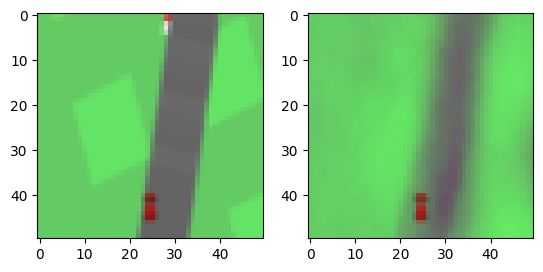

In [7]:
imglen = len(os.listdir(img_dir))
img_name = f"img{random.randint(0, imglen)}.png"
img = Image.open(os.path.join(img_dir, img_name))
imgt = ttf.pil_to_tensor(img).to(hparams.device).unsqueeze(0).float() / 255
imgt = imgt.to("mps")
vae_model.model.to("mps")
res, kl = vae_model.model(imgt)
print(torch.nn.functional.mse_loss(imgt, res))
res = res.squeeze(0).detach().cpu()
fig, axes = plt.subplots(1,2)
axes[0].imshow(img)
axes[1].imshow(ttf.to_pil_image(res))